In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.patches import Polygon
from matplotlib.colorbar import ColorbarBase
from PIL import Image

%config InlineBackend.figure_format = 'retina'

## Plot 1, Median Housing Prices

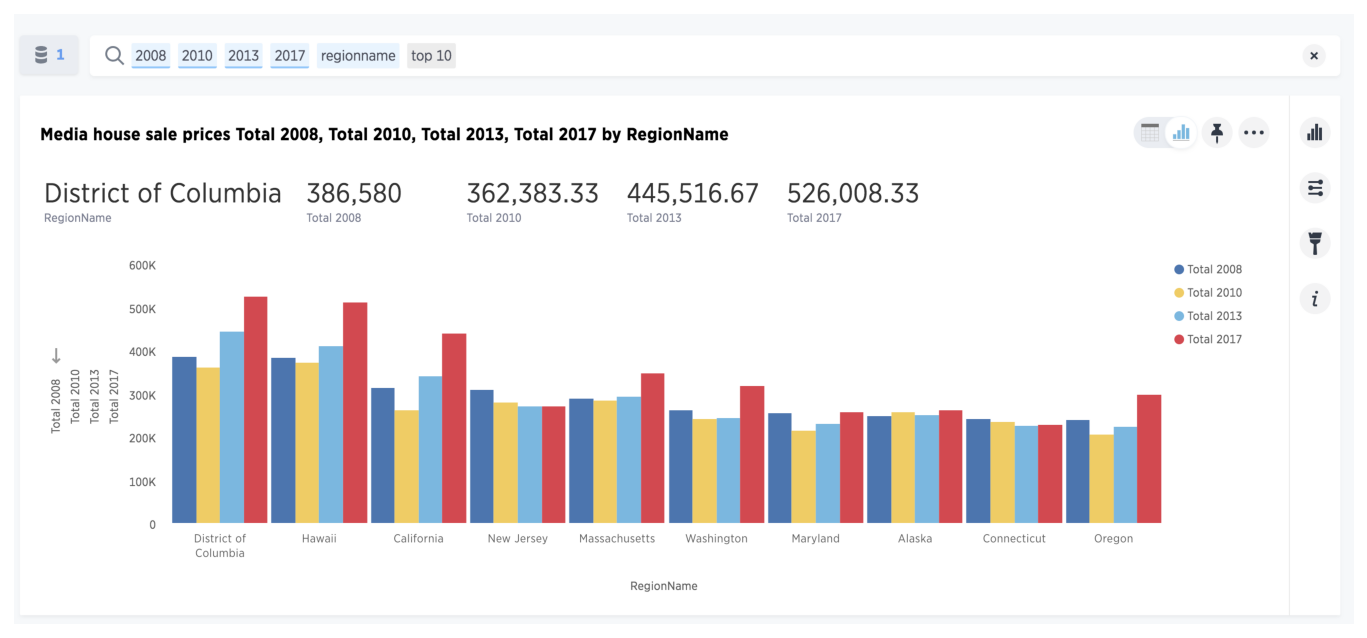

In [2]:
# show the original plot
fig, ax = plt.subplots(figsize=(12,8))

im = Image.open("static/2008_2017_median_house_prices.png")

ax.axis('off')
plt.imshow(im)
plt.show()

I downloaded the Monthly View of the Raw Median Sales Prices at [Zillow](https://www.zillow.com/research/data/) under the Inventory and Sales dragdown menu.

In [3]:
df = pd.read_csv('raw_median_sale_price.csv')

In [4]:
df.dtypes
len(df.StateName.unique())-1 # 40, not including NaN for the overall US

40

To get the data we need, need a few steps,  

- 1) Filter down columns to only columns in years we want
    - The original plot only used the top 10 states, but strangely, the data source which they linked only contains data on 40 different states, so I am going to change direction a bit. We are not going to plot every state and highlight some of the states which were present in the original plot
- 2) Compute average median values for each year
- 3) Plot years as line plots

In [5]:
# 1
red_df = df.copy()
red_df.drop(['RegionID','SizeRank'], axis=1, inplace=True) # don't need these columns


# create a fake 'state' indicator for the countries total median
red_df.loc[red_df.RegionName == 'United States', 'StateName'] = 'USA'

red_df.shape # 121, 49

(121, 153)

In [6]:
# 2

# In order to compute average for all medians for each year, we need to 
# first transpose the dataframe, groupby the years, and then we can proceed
temp_df = red_df.drop('RegionName', axis=1) # remove useless column
temp_df = temp_df.groupby('StateName').mean() # get the average median value for each state
 
temp_df = temp_df.T # transpose the df
temp_df = temp_df.reset_index().rename(columns={'index':'yr'}) # pull the year out of the index
temp_df.loc[:, 'yr'] = temp_df.yr.str[:4] # reduce date to just be the year
temp_df.set_index('yr', inplace=True) # put yr back in as index, now able to groupby
temp_df = temp_df.stack('StateName').groupby(['yr','StateName']).mean() # stack by the unique states, and years
temp_df = temp_df.unstack('StateName') # unstack to get a usable df

final_df = temp_df.reset_index() # reset_index to get the yr as a column
final_df.head()

StateName,yr,AL,AR,AZ,CA,CO,CT,DC,FL,GA,...,PA,RI,SC,TN,TX,USA,UT,VA,WA,WI
0,2008,145140.454545,136136.363636,208363.636364,360555.398601,221301.803030,304553.939394,358081.545455,187696.136364,154800.254545,...,178233.022727,246240.909091,163718.909091,137422.909091,146692.022727,194323.363636,210441.878788,223693.181818,340083.454545,197050.000000
1,2009,142958.250000,137659.750000,171853.458333,298359.935897,210197.861111,277479.166667,321655.000000,152258.812500,144328.250000,...,171636.541667,218741.666667,156574.833333,135390.150000,142464.427083,177686.666667,201099.027778,214443.208333,315277.166667,187783.333333
2,2010,144142.916667,142220.833333,157753.416667,290900.320513,217995.583333,291174.555556,323640.250000,139415.756944,136299.650000,...,174654.687500,220729.166667,160134.416667,134190.500000,143932.128472,177250.000000,193548.305556,217114.416667,307733.500000,189956.250000
3,2011,144764.166667,141138.916667,141005.083333,273480.461538,217902.055556,278026.388889,335510.666667,131556.256944,131276.483333,...,169532.291667,209487.500000,161540.694444,135191.150000,139901.203704,170945.833333,177721.500000,207827.583333,280144.166667,184486.583333
4,2012,156325.000000,144750.000000,155628.041667,280994.391026,227593.513889,267446.111111,345190.083333,138360.048611,140360.300000,...,170298.437500,204250.000000,164369.333333,138397.366667,146551.425926,175541.666667,183079.361111,207817.125000,279669.583333,178722.750000


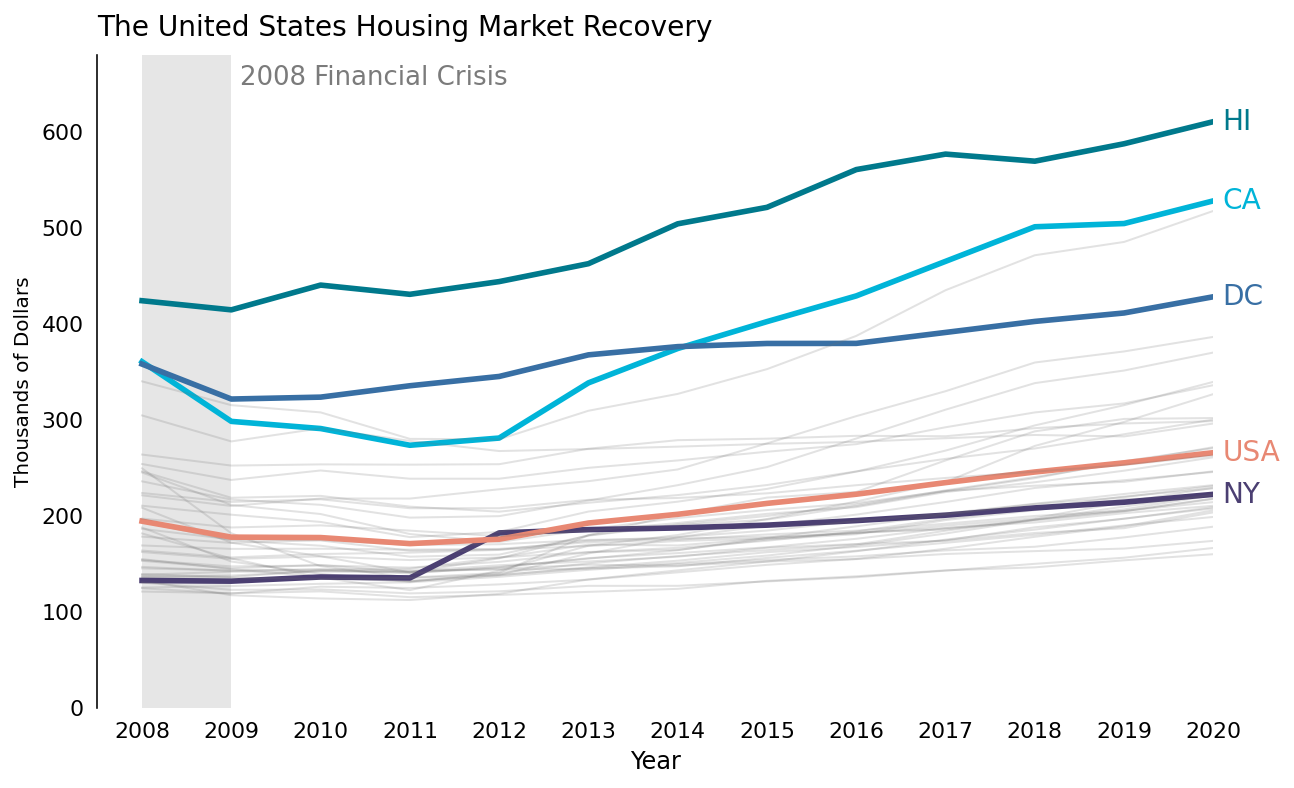

In [8]:
# 3
# lets try out a line plot with all this data

states = final_df.columns[1:].values # get all states, don't include yr column
# set up colors for notable states
notable_states = {
    'DC': '#386fa4',
    'CA': '#00b4d8',
    'USA': '#e88873',
    'NY': '#4b3f72',
    'HI': '#00798C',
}

fig, ax = plt.subplots(figsize=(10,6))

# set up axes and x, y limits
for loc, spine in ax.spines.items():
    if loc != 'left':
        spine.set_visible(False)

ax.set_ylim(0, 680_000)
ax.set_xlim(-.5, 12)
ax.tick_params('both', width=0) # remove ticks
ax.set_xticklabels(range(2008, 2021), fontdict={'fontsize': '11'})
ax.set_yticklabels(range(0, 700, 100), {'fontsize': '11'})

# create a patch for the 2008 financial crisis
rect = patches.Rectangle(
    (0, 0), width=1, height=ax.get_ylim()[1],
    facecolor='#0f0f0f', edgecolor=None,
    alpha=.1
)
ax.add_patch(rect)

# text for patch
ax.text(
    1.1, ax.get_ylim()[1]-10_000,
    '2008 Financial Crisis',
    ha='left', va='top',
    color='#0f0f0f', fontsize=13, alpha=.55
)

# plot each state
for state in states:
    color = '#6f6f6f'
    alpha = .2
    lw = 1
    if state in notable_states.keys():
        color = notable_states[state]
        alpha = 1
        lw = 2.8
        
        # label for each notable state
        ax.text(
            12.1, final_df.loc[:, state][12],
            state,
            va='center',
            fontsize=14,
            color=color, 
        )
    
    # plot the line
    ax.plot(
        final_df.yr, final_df.loc[:, state],
        color=color, alpha=alpha, lw=lw       
    )

# labels
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Thousands of Dollars')
# title
ax.text(
    -.5, 700_000,
    'The United States Housing Market Recovery',
    fontsize=14
)

plt.savefig('static/aftermath.png')
plt.show()

### Redesign  
This plot was a part of an analysis on rising homelessness, however, I chose to simply focus on the data that this plot presented as a standalone remark on housing prices. The multiple bar chart was truly hard to understand and it was not easy to compare different states' median prices as the original artist intended. I decided to use a line chart and change the axes the original plot was built on. It didn't make sense to use different states on the x axis when time series data is involved. The first big issue I had was that the dataset associated with the plot was missing 10 US states, a few of which appeared in the original plot. I decided to plot data on the 40 states that I did have and then highlight the few that appeeared in the original. The second issue was that the original plot only used data from for years at uneven intervals, 2008, 2010, 2013, and 2017. It doesn't make sense to plot time series data with uneven time gaps, so I plotted all years from 2008-2020 to observe a smooth, realistic passage through time. I used the Gestalt principle of enclosure by drawing a light grey rectangle over the 2008 financial crisis because the original author was trying to show how housing prices sank after this crisis, but then rose quickly in the following years. Finally, I highlighted a few US states with very large urban populations, which also appeared in the original. I used darker blue colors for highlighted states which contrasted from the orange line, the average median sale price over all states. Overall, this plot shows us that while most states prices either stayed the same or slightly suffered, California's housing market plummeted in the years following the 2008 financial crisis, but nearly all states have had steadily increasing housing prices since 2013.

## Plot 2, Kindle Reviews

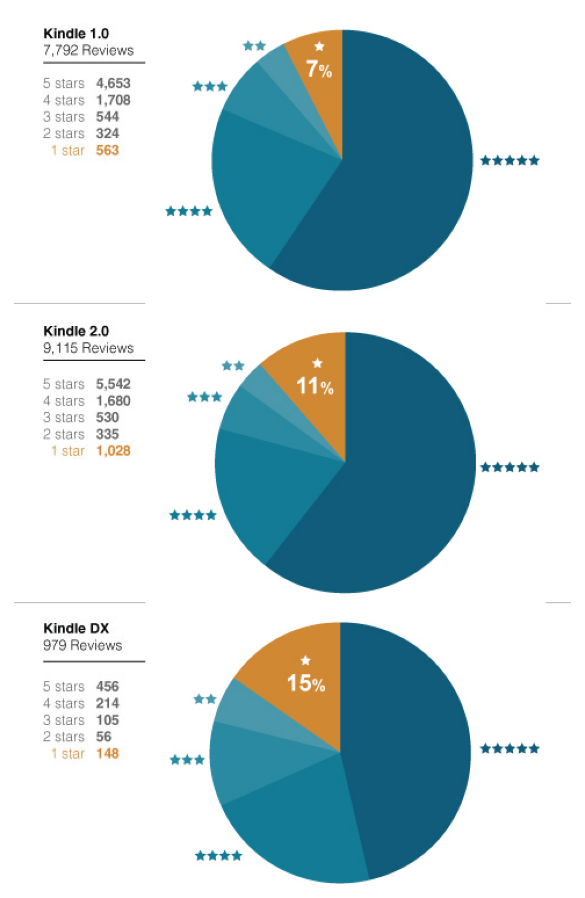

In [11]:
im = Image.open('static/kindle_reviews.jpg')

fig, ax = plt.subplots(figsize=(8,8))

plt.axis('off')
plt.imshow(im)
plt.show()

In [12]:
# 1

# initialize the number of each star of ratings for each kindle version

from collections import defaultdict

kindles = {
    '1.0': np.array([563,324,544,1_708,4_653]),
    '2.0': np.array([1_028,335,530,1_680,5_542]),
    'DX':  np.array([148,56,105,214,456])
}

# create dictionary for each star ratings for ease of plotting
stars = defaultdict(list)

for version, ratings in kindles.items():
    norm_ratings = ratings / sum(ratings) # normalize by getting proportions
    for i in range(5):
        stars[i+1].append(norm_ratings[i]) # append the proportion for each star rating

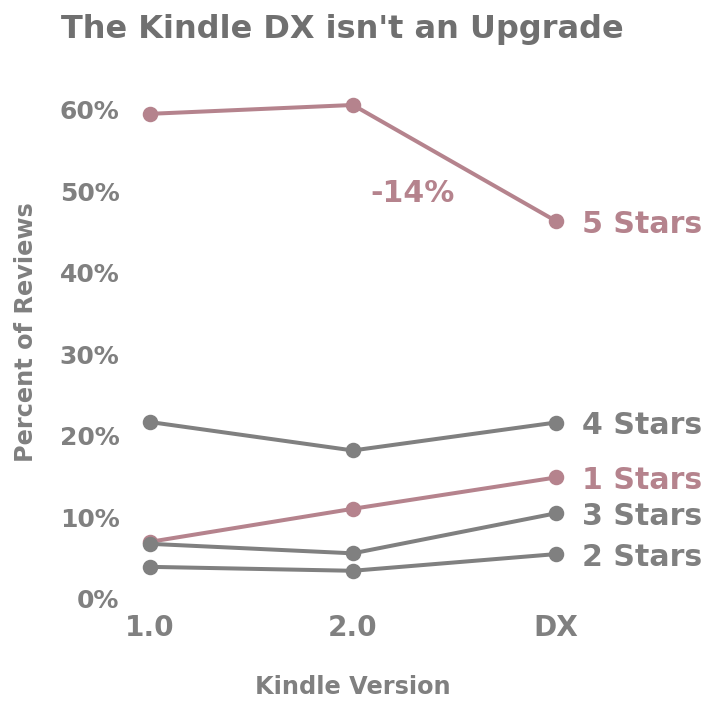

In [13]:
# 2

fig, ax = plt.subplots(figsize=(4, 6))

# clean up axes
for loc, spine in ax.spines.items():
    spine.set_visible(False)

ax.set_xlim(-.1, 2.1)
ax.set_ylim(-.1, .7)
ax.set_xticks([])
ax.tick_params('both', width=0) # remove ticks
ax.set_yticks([]) # remove y tick labels

for star, ratings in stars.items():
    color = 'grey'

    if star == 5 or star == 1:
        color = '#b5838d'
    
    ax.plot(
        [0,1,2], ratings,
        '.-',
        markersize=13.5,
        lw=2, color=color
    )
    
    ax.text(
        2.13, ratings[2]-.003,
        f'{star} Stars',
        ha='left', va='center',
        color=color, weight='bold', 
        fontsize=15
    )

# annotations, labels, and titles

# x tick labels
for i, label in enumerate(['1.0','2.0','DX']):
    ax.text(
        i, -.05,
        label,
        ha='center', va='bottom',
        color='grey', fontsize=14,
        weight='bold'
    )

# x axis label
ax.text(
    1, -.12,
    'Kindle Version',
    ha='center', va='bottom',
    color='grey', fontsize=12,
    weight='bold'
)

# title
ax.text(
    -.44, .72,
    "The Kindle DX isn't an Upgrade",
    ha='left', va='top',
    color='#707070', fontsize=16,
    weight='bold'
)

# y tick labels
for pct in range(0, 70, 10):
    ax.text(
        -.15, pct / 100,
        f'{pct}%',
        ha='right', va='center',
        color='grey', fontsize=12.5,
        weight='bold'
    )

# show decline
ax.text(
    1.5, .5,
    f'-{(stars[5][1]-stars[5][2])*100:.0f}%',
    ha='right', va='center',
    color='#b5838d', fontsize=15,
    weight='bold'
)

# y-axis label
ax.text(
    -.55, .33,
    'Percent of Reviews',
    rotation=90,
    ha='right', va='center',
    color="grey",
    weight='bold', fontsize=12
)
    
plt.savefig('static/kindles_slope_graph.png', bbox_inches='tight')
plt.show()

### Redesign Process
After looking at the pie charts for this data, I could start to see that they were trying to show how well received the newest Kindle model was. From the pie charts, its hard to compare the different percentages of ratings besides the 1 star reviews which are directly labeled. I thought that since versions roll out with time, it could be interesting to see the change in customer satisfaction (number of reviews per star) as a slopegraph would help us understand more how the products were received with each new version. First, I had to build the data. I created a dictionary with the raw number of reviews per star per kindle version and normalized to get a percent of total reviews. Then, I plotted each type of review (per star type) over the three versions, 1.0, 2.0, and DX. The original charts highlighted only one star reviews, but the slopegraph revealed a startling statistic: the Kindle DX had the lowest percentage of 5 star reviews across all three models. I decided to highlight this decrease with color and also marked the 14% decline with a simple annotation. I also highlighted the percentage of 1 star reviews as the original artist did to show the rising level of dissatisfaction from version 1.0 to the DX. Overall, this slopegraph shows us that the Kindle DX was not as well received as its previous iterations, and 1 star ratings have steadily, almost linearly, increased since the first Kindle.